# Example 5: Risk parity

This example follows from previous ones. If something in the preamble is confusing, it is explained there.

This example focuses on the `RP` optimisation type of `Portfolio`.

## 1. Downloading the data

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "YFinance", "Clarabel", "HiGHS", "CovarianceEstimation", "SparseArrays"])
using Clarabel, CovarianceEstimation, DataFrames, Dates, GraphRecipes, HiGHS, YFinance,
      PortfolioOptimiser, Statistics, StatsBase, StatsPlots, TimeSeries, LinearAlgebra,
      PrettyTables

fmt1 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return if isa(v, Number)
            "$(round(v*100, digits=3)) %"
        else
            v
        end
    end
end;

function stock_price_to_time_array(x)
    coln = collect(keys(x))[3:end] # only get the keys that are not ticker or datetime
    m = hcat([x[k] for k ∈ coln]...) #Convert the dictionary into a matrix
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end
assets = ["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC", "LULU",
          "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT", "SAVE", "SBUX",
          "SIRI", "STX", "TLRY", "TSLA"]
Date_0 = "2019-01-01"
Date_1 = "2023-01-01"
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets));

## 2. Instantiating an instance of `Portfolio`.

We'll compute basic statistics for this.

In [2]:
portfolio = Portfolio(; prices = prices,
                      # Continuous optimiser.
                      solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                       :check_sol => (allow_local = true,
                                                                      allow_almost = true),
                                                       :params => Dict("verbose" => false))),
                      # MIP optimiser for the discrete allocation.
                      alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                          :check_sol => (allow_local = true,
                                                                         allow_almost = true),
                                                          :params => Dict("log_to_console" => false))));

asset_statistics!(portfolio)

## 3. Optimising the portfolio

The `RP` uses a risk budget vector for defining the risk contribution of each asset. The vector defaults to equal risk contribution for all assets.

Risk parity portfolios don't use a user-provided objective function. They minimise the risk subject to a constraint that minimises the deviation

In [3]:
rm = SD()
type = RP()
w1 = optimise!(portfolio; type = type, rm = rm)
pretty_table(w1; formatters = fmt1)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│     AAL │  2.962 % │
│    AAPL │  4.686 % │
│     AMC │  1.397 % │
│      BB │  2.786 % │
│     BBY │   4.25 % │
│    DELL │  4.448 % │
│      DG │ 10.129 % │
│     DRS │  4.111 % │
│     GME │  1.698 % │
│    INTC │  4.521 % │
│    LULU │  4.199 % │
│    MARA │  1.715 % │
│     MCI │  9.479 % │
│    MSFT │  5.025 % │
│    NKLA │  2.642 % │
│    NVAX │    2.5 % │
│    NVDA │  3.035 % │
│    PARA │  3.478 % │
│    PLNT │  3.441 % │
│    SAVE │  2.835 % │
│    SBUX │  5.266 % │
│    SIRI │  5.804 % │
│     STX │  4.504 % │
│    TLRY │  2.192 % │
│    TSLA │  2.896 % │
└─────────┴──────────┘


We can check that the risk budget and risk contribution match.

In [4]:
# Risk budget.
rb = portfolio.risk_budget
# Compute the risk contribution, for the `SD` risk measure.
rc = risk_contribution(portfolio; type = :RP, rm = rm)
# Normalise risk contribution so it adds up to 1 a.k.a. 100%.
rc ./= sum(rc)

pretty_table(hcat(w1, DataFrame(; budget = rb, contribution = rc)); formatters = fmt1)

┌─────────┬──────────┬─────────┬──────────────┐
│ tickers │  weights │  budget │ contribution │
│  String │  Float64 │ Float64 │      Float64 │
├─────────┼──────────┼─────────┼──────────────┤
│     AAL │  2.962 % │   4.0 % │        4.0 % │
│    AAPL │  4.686 % │   4.0 % │        4.0 % │
│     AMC │  1.397 % │   4.0 % │        4.0 % │
│      BB │  2.786 % │   4.0 % │        4.0 % │
│     BBY │   4.25 % │   4.0 % │        4.0 % │
│    DELL │  4.448 % │   4.0 % │        4.0 % │
│      DG │ 10.129 % │   4.0 % │        4.0 % │
│     DRS │  4.111 % │   4.0 % │        4.0 % │
│     GME │  1.698 % │   4.0 % │        4.0 % │
│    INTC │  4.521 % │   4.0 % │        4.0 % │
│    LULU │  4.199 % │   4.0 % │        4.0 % │
│    MARA │  1.715 % │   4.0 % │        4.0 % │
│     MCI │  9.479 % │   4.0 % │        4.0 % │
│    MSFT │  5.025 % │   4.0 % │        4.0 % │
│    NKLA │  2.642 % │   4.0 % │        4.0 % │
│    NVAX │    2.5 % │   4.0 % │        4.0 % │
│    NVDA │  3.035 % │   4.0 % │        

As you can see, the weights of each asset in the portfolio are such that the asset contributes 4% of the risk of the portfolio. This is because we used the default value for the risk budget, which defaults to equal risk contribution per asset, which is equal to `1/N`, where `N` is the number of assets.

We can also plot the risk contribution in asbolute and relative terms.

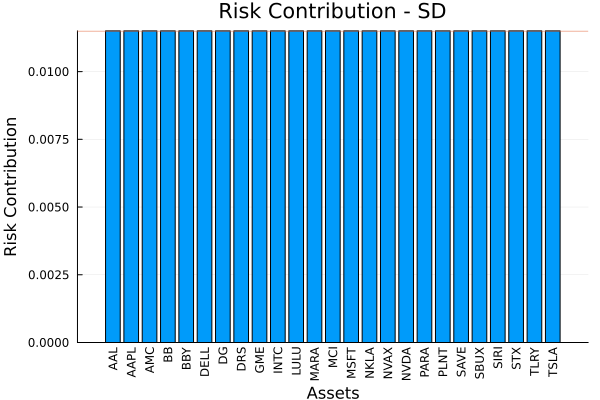

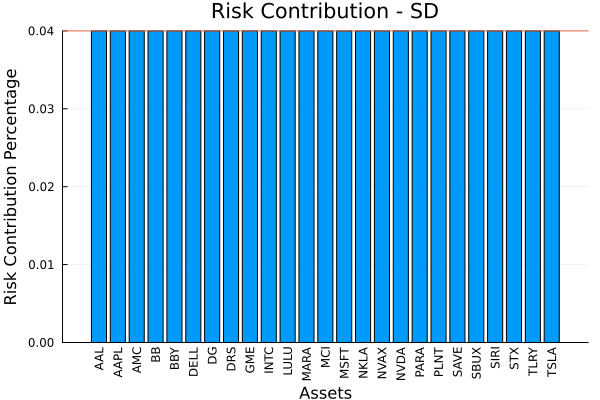

In [5]:
display(plot_risk_contribution(portfolio; rm = rm, type = :RP, percentage = false))
display(plot_risk_contribution(portfolio; rm = rm, type = :RP, percentage = true))

Lets change the risk budget to something a little bit more interesting. The risk budget can be provided from to the `Portfolio` constructor, or after instatiation. Either way, the risk budget will be normalised to add up to 1. If using the latter method, the element type of the vector provided must match that of `risk_budget` because the normalisation is done in-place to avoid unecessary allocations.

In [6]:
x = range(; start = 0, stop = 2pi, length = length(w1.weights))
portfolio.risk_budget = sin.(x) .^ 2;

Lets optimise using this risk budget to see what happens.

In [7]:
w1 = optimise!(portfolio; type = type, rm = rm)
rb = portfolio.risk_budget
# Compute the risk contribution, for the `SD` risk measure.
rc = risk_contribution(portfolio; type = :RP, rm = rm)
# Normalise risk contribution so it adds up to 1 a.k.a. 100%.
rc ./= sum(rc)
pretty_table(hcat(w1, DataFrame(; budget = rb, contribution = rc)); formatters = fmt1)

┌─────────┬─────────┬─────────┬──────────────┐
│ tickers │ weights │  budget │ contribution │
│  String │ Float64 │ Float64 │      Float64 │
├─────────┼─────────┼─────────┼──────────────┤
│     AAL │   0.0 % │   0.0 % │        0.0 % │
│    AAPL │ 0.685 % │ 0.558 % │      0.558 % │
│     AMC │ 0.783 % │ 2.083 % │      2.083 % │
│      BB │   3.0 % │ 4.167 % │      4.166 % │
│     BBY │  6.35 % │  6.25 % │       6.25 % │
│    DELL │ 8.318 % │ 7.775 % │      7.775 % │
│      DG │ 18.62 % │ 8.333 % │      8.333 % │
│     DRS │ 7.266 % │ 7.775 % │      7.775 % │
│     GME │ 2.599 % │  6.25 % │       6.25 % │
│    INTC │ 4.732 % │ 4.167 % │      4.167 % │
│    LULU │ 2.225 % │ 2.083 % │      2.083 % │
│    MARA │  0.29 % │ 0.558 % │      0.558 % │
│     MCI │   0.0 % │   0.0 % │        0.0 % │
│    MSFT │  0.73 % │ 0.558 % │      0.558 % │
│    NKLA │ 1.549 % │ 2.083 % │      2.083 % │
│    NVAX │   2.7 % │ 4.167 % │      4.167 % │
│    NVDA │ 4.869 % │  6.25 % │       6.25 % │
│    PARA │ 6

Lets plot the results.

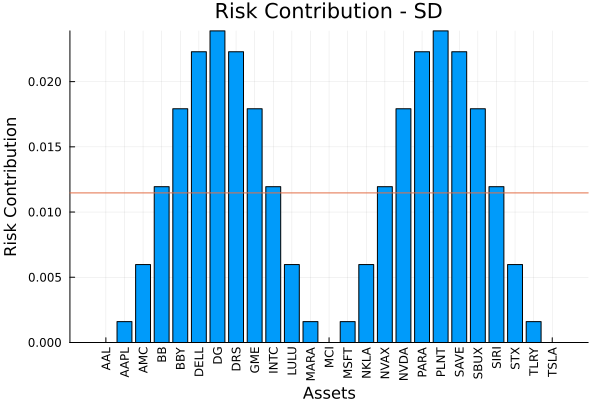

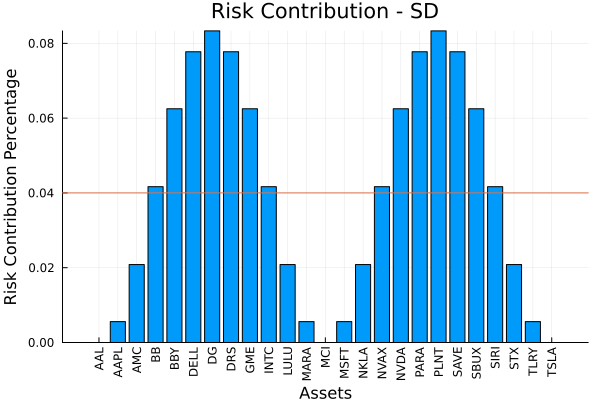

In [8]:
display(plot_risk_contribution(portfolio; rm = rm, type = :RP, percentage = false))
display(plot_risk_contribution(portfolio; rm = rm, type = :RP, percentage = true))

We've used the `SD` risk function for computing the risk parity portfolio, as well as for computing and plotting the risk contribution, but there's nothing stopping us from computing the risk contribution and/or plotting the risk contribution for risk measures other than the one that was optimised.

┌─────────┬─────────┬───────────┬───────────────────┐
│ tickers │ weights │ budget_SD │ contribution_CDaR │
│  String │ Float64 │   Float64 │           Float64 │
├─────────┼─────────┼───────────┼───────────────────┤
│     AAL │   0.0 % │     0.0 % │             0.0 % │
│    AAPL │ 0.685 % │   0.558 % │           0.163 % │
│     AMC │ 0.783 % │   2.083 % │           2.795 % │
│      BB │   3.0 % │   4.167 % │           6.571 % │
│     BBY │  6.35 % │    6.25 % │          10.208 % │
│    DELL │ 8.318 % │   7.775 % │           9.155 % │
│      DG │ 18.62 % │   8.333 % │          -3.633 % │
│     DRS │ 7.266 % │   7.775 % │           1.357 % │
│     GME │ 2.599 % │    6.25 % │            2.02 % │
│    INTC │ 4.732 % │   4.167 % │           6.682 % │
│    LULU │ 2.225 % │   2.083 % │           2.507 % │
│    MARA │  0.29 % │   0.558 % │           1.047 % │
│     MCI │   0.0 % │     0.0 % │             0.0 % │
│    MSFT │  0.73 % │   0.558 % │           0.626 % │
│    NKLA │ 1.549 % │   2.08

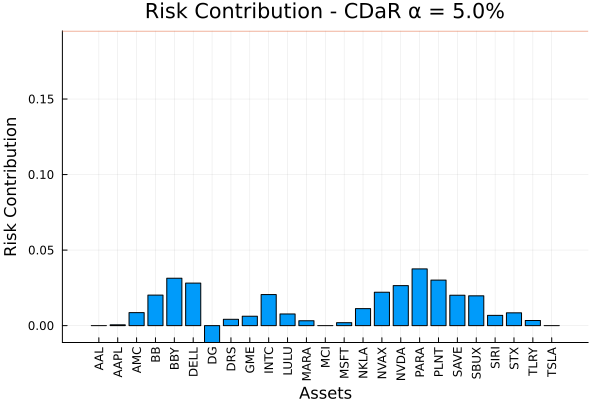

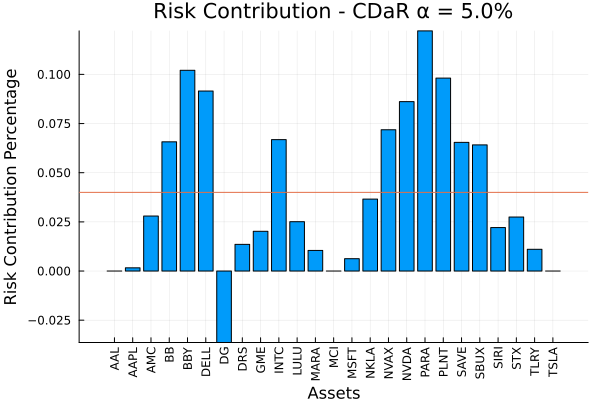

In [9]:
# Compute the risk contribution, for the `CDaR` risk measure.
rc = risk_contribution(portfolio; type = :RP, rm = CDaR())
# Normalise risk contribution so it adds up to 1 a.k.a. 100%.
rc ./= sum(rc)
pretty_table(hcat(w1, DataFrame(; budget_SD = rb, contribution_CDaR = rc));
             formatters = fmt1)

display(plot_risk_contribution(portfolio; rm = CDaR(), type = :RP, percentage = false))
display(plot_risk_contribution(portfolio; rm = CDaR(), type = :RP, percentage = true))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*